In [1]:
import random
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms as T
from PIL import Image
import os
from glob import glob
import wandb
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
#test 


In [116]:
wandb.login()
wandb.init(project="comic-vs-manga-classification")


wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


epoch,▁▁▂▃▃▄▅▆▆▇█
test_accuracy,██▁▁
train_accuracy,▁▃▄▆▇██████
train_loss,█▃▂▂▂▁▁▁▁▁▁
val_accuracy,▁▆▆██▇▇▆▇▆▅
val_loss,▁▁▁▁▂▃▄▅▇▇█
epoch,10
test_accuracy,38.33333
train_accuracy,99.92652
train_loss,0.00525
val_accuracy,69.6


In [117]:
class CustomDataset(Dataset):
    def __init__(self, root, data, transformations=None, im_files=[".jpg", ".jpeg", ".png"]):
        self.transformations, self.data = transformations, data
        self.im_paths = []
        
        for im_file in im_files:
            self.im_paths.extend(sorted(glob(os.path.join(root, data, '*', '*' + im_file))))
        
        self.cls_names, self.cls_counts, count = {}, {}, 0
        for idx, im_path in enumerate(self.im_paths):
            class_name = os.path.basename(os.path.dirname(im_path))
            if class_name not in self.cls_names:
                self.cls_names[class_name] = count
                self.cls_counts[class_name] = 1
                count += 1
            else:
                self.cls_counts[class_name] += 1

        print(f'{data} dataset - Number of images: {len(self.im_paths)}')

    def __len__(self):
        return len(self.im_paths)

    def __getitem__(self, idx):
        im_path = self.im_paths[idx]
        im = Image.open(im_path).convert("RGB")
        gt = self.cls_names[os.path.basename(os.path.dirname(im_path))]

        if self.transformations is not None:
            im = self.transformations(im)

        return im, gt


In [118]:
def get_dls(root, transformations, bs, ns=0):  # Set num_workers to 0 for debugging
    tr_ds = CustomDataset(root=root, data="train", transformations=transformations)
    vl_ds = CustomDataset(root=root, data="validation", transformations=transformations)
    ts_ds = CustomDataset(root=root, data="test", transformations=transformations)
    
    tr_dl = DataLoader(tr_ds, batch_size=bs, shuffle=True, num_workers=ns)
    val_dl = DataLoader(vl_ds, batch_size=bs, shuffle=False, num_workers=ns)
    ts_dl = DataLoader(ts_ds, batch_size=1, shuffle=False, num_workers=ns)
    
    return tr_dl, val_dl, ts_dl, tr_ds.cls_names


In [119]:
root = "data"
mean, std, im_size = [0.485, 0.456, 0.406], [0.229, 0.224, 0.225], 224
tfs = T.Compose([T.Resize((im_size, im_size)), T.ToTensor(), T.Normalize(mean=mean, std=std)])
tr_dl, val_dl, ts_dl, classes = get_dls(root=root, transformations=tfs, bs=32)

print(f'Training DataLoader Length: {len(tr_dl)}')
print(f'Validation DataLoader Length: {len(val_dl)}')
print(f'Test DataLoader Length: {len(ts_dl)}')
print(f'Classes: {classes}')


train dataset - Number of images: 1361
validation dataset - Number of images: 500
test dataset - Number of images: 60
Training DataLoader Length: 43
Validation DataLoader Length: 16
Test DataLoader Length: 60
Classes: {'classic': 0, 'manga': 1}


In [120]:
def test_data_loading(dl):
    data_iter = iter(dl)
    for i in range(5):  # Load 5 batches to check for issues
        try:
            images, labels = next(data_iter)
            print(f'Batch {i+1}: Loaded {images.size(0)} images.')
        except StopIteration:
            print(f'Batch {i+1}: No more data.')
            break

# Test loading training data
print("Training DataLoader:")
test_data_loading(tr_dl)
# Test loading validation data
print("Validation DataLoader:")
test_data_loading(val_dl)
# Test loading test data
print("Test DataLoader:")
test_data_loading(ts_dl)


Training DataLoader:
Batch 1: Loaded 32 images.
Batch 2: Loaded 32 images.
Batch 3: Loaded 32 images.
Batch 4: Loaded 32 images.
Batch 5: Loaded 32 images.
Validation DataLoader:
Batch 1: Loaded 32 images.
Batch 2: Loaded 32 images.
Batch 3: Loaded 32 images.
Batch 4: Loaded 32 images.
Batch 5: Loaded 32 images.
Test DataLoader:
Batch 1: Loaded 1 images.
Batch 2: Loaded 1 images.
Batch 3: Loaded 1 images.
Batch 4: Loaded 1 images.
Batch 5: Loaded 1 images.


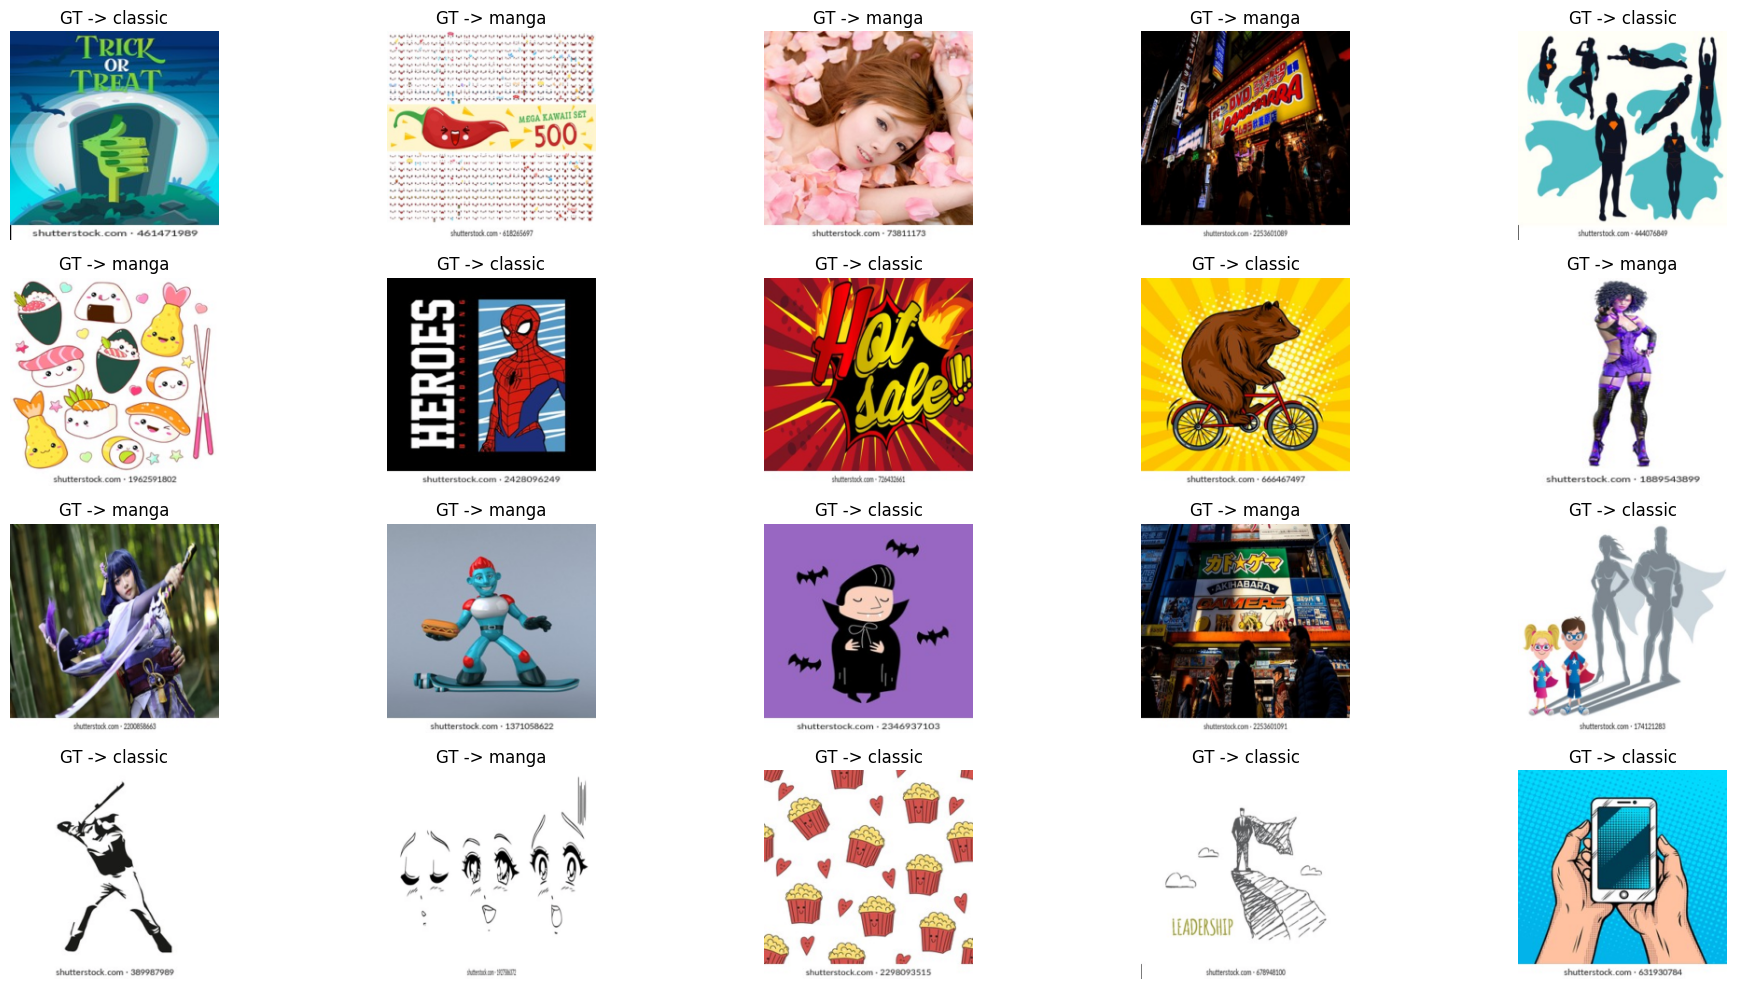

In [121]:
import random
import numpy as np
import matplotlib.pyplot as plt
import torch
from torchvision import transforms as T


def convert_tensor_to_image(tensor, t_type="rgb"):
    """
    Convert a tensor to a numpy array image with normalization reversed.
    """
    if t_type == "gray":
        transform = T.Compose([
            T.Normalize(mean=[0.0], std=[1/0.5]),
            T.Normalize(mean=[-0.5], std=[1])
        ])
    else:
        transform = T.Compose([
            T.Normalize(mean=[0.0, 0.0, 0.0], std=[1/0.229, 1/0.224, 1/0.225]),
            T.Normalize(mean=[-0.485, -0.456, -0.406], std=[1.0, 1.0, 1.0])
        ])
    
    image = (transform(tensor) * 255).detach().cpu().permute(1, 2, 0).numpy().astype(np.uint8)
    return image

def display_images(dataset, n_images, nrows, cmap_type=None, class_names=None):
    """
    Display a batch of images from the dataset.
    """
    assert cmap_type in ["rgb", "gray"], "Specify if the images are grayscale or RGB!"
    
    if cmap_type == "rgb":
        cmap_type = "viridis"
    
    plt.figure(figsize=(20, 10))
    indices = random.sample(range(len(dataset)), n_images)
    ncols = n_images // nrows

    for i, idx in enumerate(indices):
        img, label = dataset[idx]
        plt.subplot(nrows, ncols, i + 1)
        if cmap_type:
            plt.imshow(convert_tensor_to_image(img, t_type=cmap_type), cmap=cmap_type)
        else:
            plt.imshow(convert_tensor_to_image(img))
        plt.axis('off')
        if class_names is not None:
            plt.title(f"GT -> {class_names[int(label)]}")
        else:
            plt.title(f"GT -> {label}")
    
    plt.tight_layout()
    plt.show()

# Example usage with the training DataLoader
display_images(tr_dl.dataset, 20, 4, cmap_type="rgb", class_names=list(classes.keys()))


In [133]:
import torch
import torch.nn as nn
import torch.optim as optim
import wandb
import numpy as np
import matplotlib.pyplot as plt
import random
from tqdm import tqdm
from torchvision import transforms

# Set device to GPU if available, otherwise CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Define your model with Dropout
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.fc1 = nn.Linear(64 * 56 * 56, 128)
        self.dropout = nn.Dropout(0.5)  # Add dropout layer
        self.fc2 = nn.Linear(128, 2)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 64 * 56 * 56)  # Flatten the tensor
        x = F.relu(self.fc1(x))
        x = self.dropout(x)  # Apply dropout
        x = self.fc2(x)
        return x

# Instantiate the model
model = SimpleCNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Early Stopping class
class EarlyStopping:
    def __init__(self, patience=5, delta=0):
        self.patience = patience
        self.delta = delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False

    def __call__(self, val_loss, model):
        if self.best_loss is None or val_loss < self.best_loss - self.delta:
            self.best_loss = val_loss
            self.counter = 0
            torch.save(model.state_dict(), 'checkpoint.pt')  # Save the best model
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True

early_stopping = EarlyStopping(patience=5, delta=0.01)

def train_model(model, train_loader, val_loader, criterion, optimizer, epochs=10):
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        train_loss = running_loss / len(train_loader)
        train_accuracy = 100 * correct / total

        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0

        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()

        val_loss /= len(val_loader)
        val_accuracy = 100 * val_correct / val_total

        wandb.log({
            'epoch': epoch + 1,
            'train_loss': train_loss,
            'train_accuracy': train_accuracy,
            'val_loss': val_loss,
            'val_accuracy': val_accuracy
        })

        print(f'Epoch [{epoch+1}/{epochs}], Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%, Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%')

        early_stopping(val_loss, model)
        if early_stopping.early_stop:
            print("Early stopping")
            model.load_state_dict(torch.load('checkpoint.pt'))
            break

train_model(model, tr_dl, val_dl, criterion, optimizer, epochs=10)

# Evaluate on the test set
def evaluate_model(model, test_loader):
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    print(f'Test Accuracy: {accuracy:.2f}%')

evaluate_model(model, ts_dl)


Using device: cpu
Epoch [1/10], Train Loss: 1.8652, Train Accuracy: 58.41%, Val Loss: 0.6562, Val Accuracy: 56.40%
Epoch [2/10], Train Loss: 0.6256, Train Accuracy: 64.29%, Val Loss: 0.6234, Val Accuracy: 63.00%
Epoch [3/10], Train Loss: 0.6129, Train Accuracy: 67.30%, Val Loss: 0.6045, Val Accuracy: 67.40%
Epoch [4/10], Train Loss: 0.5767, Train Accuracy: 71.05%, Val Loss: 0.6005, Val Accuracy: 66.00%
Epoch [5/10], Train Loss: 0.5478, Train Accuracy: 72.23%, Val Loss: 0.6570, Val Accuracy: 64.00%
Epoch [6/10], Train Loss: 0.5086, Train Accuracy: 74.87%, Val Loss: 0.5962, Val Accuracy: 68.20%
Epoch [7/10], Train Loss: 0.4740, Train Accuracy: 77.37%, Val Loss: 0.5972, Val Accuracy: 69.80%
Epoch [8/10], Train Loss: 0.4290, Train Accuracy: 82.37%, Val Loss: 0.5678, Val Accuracy: 69.00%
Epoch [9/10], Train Loss: 0.3520, Train Accuracy: 85.60%, Val Loss: 0.5891, Val Accuracy: 71.20%
Epoch [10/10], Train Loss: 0.2705, Train Accuracy: 88.32%, Val Loss: 0.6367, Val Accuracy: 72.00%
Test Accura

In [134]:
def evaluate_model(model, test_loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    if total > 0:
        accuracy = 100 * correct / total
        print(f'Test Accuracy: {accuracy:.2f}%')
        wandb.log({'test_accuracy': accuracy})
    else:
        print("No data in the test set.")
        wandb.log({'test_accuracy': None})

evaluate_model(model, ts_dl)


Test Accuracy: 50.00%


60it [00:00, 62.81it/s]
/var/folders/7l/wr39ns_13xdbtxc49y6l0qjh0000gn/T/ipykernel_9343/1810627296.py:97: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  plt.title(f"GT -> {class_names[int(labels[idx])]} ; PRED -> {class_names[int(predictions[idx])]}", color=("green" if class_names[int(labels[idx])] == class_names[int(predictions[idx])] else "red"))


Model accuracy on test data: 0.450
Features shape: (1, 64, 112, 112)
Weights shape: (2, 128)
Reshaped features shape: (64, 12544)
Features shape: (1, 64, 112, 112)
Weights shape: (2, 128)
Reshaped features shape: (64, 12544)
Features shape: (1, 64, 112, 112)
Weights shape: (2, 128)
Reshaped features shape: (64, 12544)
Features shape: (1, 64, 112, 112)
Weights shape: (2, 128)
Reshaped features shape: (64, 12544)
Features shape: (1, 64, 112, 112)
Weights shape: (2, 128)
Reshaped features shape: (64, 12544)
Features shape: (1, 64, 112, 112)
Weights shape: (2, 128)
Reshaped features shape: (64, 12544)
Features shape: (1, 64, 112, 112)
Weights shape: (2, 128)
Reshaped features shape: (64, 12544)
Features shape: (1, 64, 112, 112)
Weights shape: (2, 128)
Reshaped features shape: (64, 12544)
Features shape: (1, 64, 112, 112)
Weights shape: (2, 128)
Reshaped features shape: (64, 12544)
Features shape: (1, 64, 112, 112)
Weights shape: (2, 128)
Reshaped features shape: (64, 12544)
Features shape:

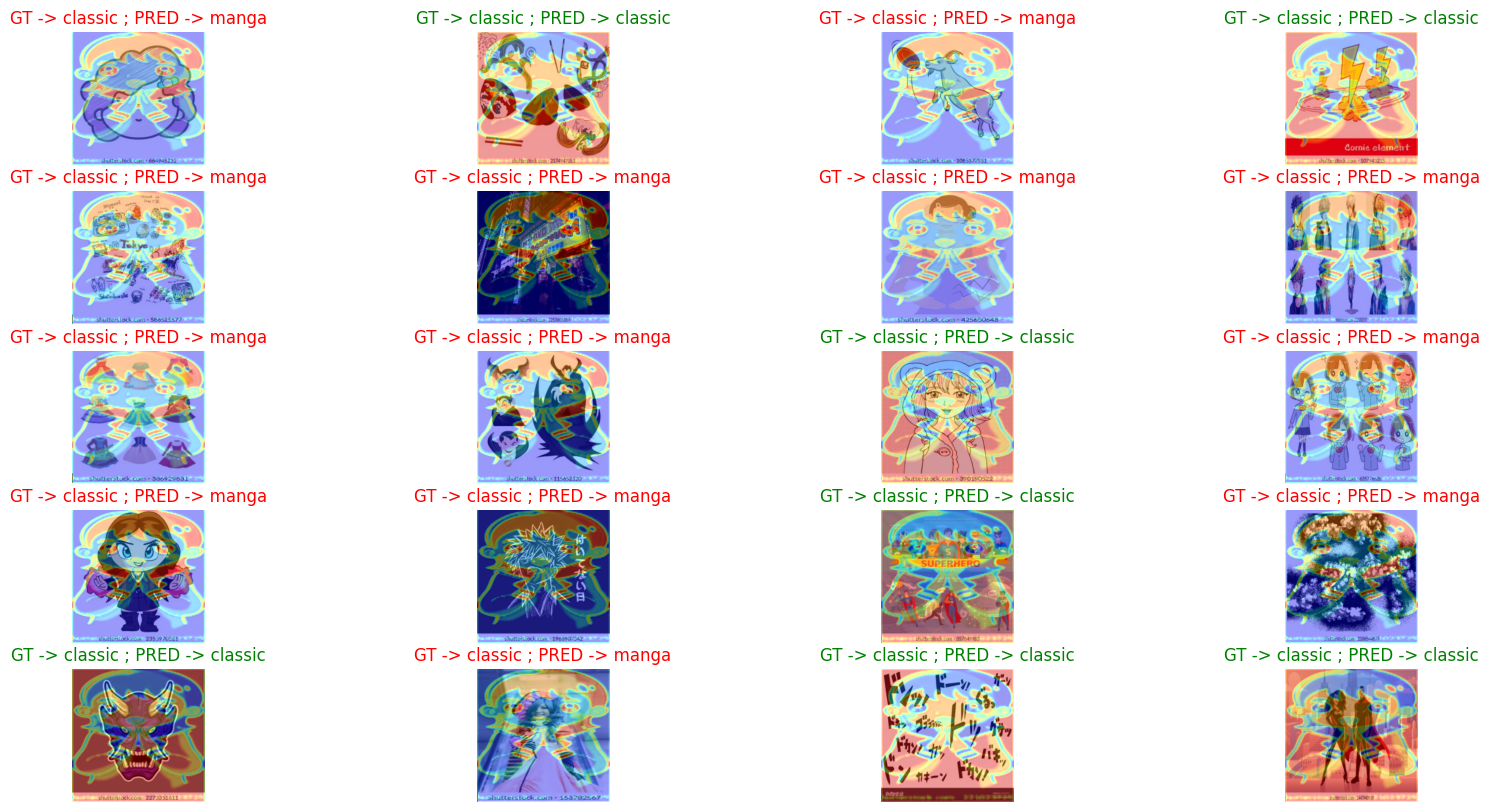

In [137]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import cv2
import random
from tqdm import tqdm
from torchvision.transforms import ToPILImage

class FeatureExtractor:
    """ Extract activations from the pretrained model """
    def __init__(self, model_layer):
        self.features = None
        self.hook = model_layer.register_forward_hook(self.save_features)

    def save_features(self, module, input, output):
        self.features = output.cpu().data.numpy()

    def remove(self):
        self.hook.remove()

def compute_cam(features, weights, class_idx):
    """
    Compute the class activation map (CAM) for the given class index.
    
    Args:
    - features: The feature maps from the convolutional layer.
    - weights: The weights from the fully connected layer.
    - class_idx: The index of the target class.
    
    Returns:
    - cam: The class activation map.
    """
    # Print shapes for debugging
    print(f"Features shape: {features.shape}")
    print(f"Weights shape: {weights.shape}")
    
    # features shape: (batch_size, num_channels, height, width)
    # weights shape: (num_classes, num_fc_features)
    
    # Reshape features to (num_channels, height * width)
    batch_size, num_channels, height, width = features.shape
    features_reshaped = features[0].reshape((num_channels, height * width))
    
    # Print reshaped features for debugging
    print(f"Reshaped features shape: {features_reshaped.shape}")
    
    # Reduce the weights to match the number of channels in the final conv layer
    weights_reduced = weights[:, :num_channels]
    
    # Dot product of the weights and the reshaped features
    cam = weights_reduced[class_idx].dot(features_reshaped)
    
    # Reshape the result back to the spatial dimensions
    cam = cam.reshape(height, width)
    
    # Normalize the CAM
    cam = (cam - np.min(cam)) / (np.max(cam) - np.min(cam))
    return cam

def tensor_to_image(tensor, mean, std):
    for t, m, s in zip(tensor, mean, std):
        t.mul_(s).add_(m)
    np_image = tensor.numpy()
    np_image = np.transpose(np_image, (1, 2, 0))
    np_image = np.clip(np_image, 0, 1)
    return np_image

def run_inference_with_gradcam(model, device, test_loader, num_images, rows, final_conv_layer, fc_weights, class_names=None):
    weights, accuracy = np.squeeze(fc_weights[0].cpu().data.numpy()), 0
    feature_extractor = FeatureExtractor(final_conv_layer)
    predictions, imgs, labels = [], [], []

    for idx, (images, gts) in tqdm(enumerate(test_loader)):
        images, gts = images.to(device), gts.to(device)
        outputs = model(images)
        preds = torch.argmax(outputs, dim=1)
        accuracy += (preds == gts).sum().item()
        imgs.append(images.cpu())
        predictions.append(preds.cpu().numpy())
        labels.append(gts.cpu().numpy())

    print(f"Model accuracy on test data: {(accuracy / len(test_loader.dataset)):.3f}")

    plt.figure(figsize=(20, 10))
    indices = random.sample(range(len(imgs)), num_images)

    for i, idx in enumerate(indices):
        img = imgs[idx].squeeze()
        pred_idx = predictions[idx]
        heatmap = compute_cam(feature_extractor.features, weights, pred_idx)

        plt.subplot(rows, num_images // rows, i + 1)
        plt.imshow(tensor_to_image(img, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]))
        plt.imshow(cv2.resize(heatmap, (img.shape[1], img.shape[2])), alpha=0.4, cmap='jet')
        plt.axis('off')
        if class_names is not None:
            plt.title(f"GT -> {class_names[int(labels[idx])]} ; PRED -> {class_names[int(predictions[idx])]}", color=("green" if class_names[int(labels[idx])] == class_names[int(predictions[idx])] else "red"))
        else:
            plt.title(f"GT -> {labels[idx]} ; PRED -> {predictions[idx]}")

    plt.show()

# Load the model
model = SimpleCNN()  # Replace SimpleCNN with your actual model class if different
model.load_state_dict(torch.load("best_model.pth"))
model.eval()

# Hook to the final conv layer
final_conv_layer = model.conv2  # Assuming conv2 is the final conv layer, adjust accordingly
fc_weights = list(model.fc2.parameters())

# Run inference with GradCAM
run_inference_with_gradcam(model=model.to(device), device=device, test_loader=ts_dl, num_images=20, rows=5, final_conv_layer=final_conv_layer, fc_weights=fc_weights, class_names=list(classes.keys()))


In [1]:
print("hello")
#test


hello
